In [5]:
import numpy as np
from matplotlib import pyplot as plt
import tempfile
import os
import shutil
import glob
import tqdm
import pandas as pd
import pyart
from load_radar import load_radar
import datetime as dt
import zipfile
import matplotlib.pyplot as plt
import tobac
from tint import Cell_tracks
        
%matplotlib inline


In [11]:
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: "+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)
                        
rid = "2"; #times = [dt.datetime(2020,1,31,3), dt.datetime(2020,1,31,9)]
times=[dt.datetime(2018,12,27,10,17), dt.datetime(2018,12,27,10,19)]

#Re-load gridded radar files, as well as raw radar files, in a format ready to send to TINT
unpack_level1b(rid, times)
grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                "%Y%m%d%H%M%S") for f in grid_files])
target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]
grids = (pyart.io.read_grid(fn) for fn in target_files)
radars = (None for fn in grid_files)

#Initialise TINT tracks and set tracking parameters
tracks_obj = Cell_tracks("corrected_reflectivity")
tracks_obj.params["FIELD_THRESH"]=30
tracks_obj.params["MIN_SIZE"]=15
tracks_obj.params["MIN_VOL"]=30
tracks_obj.params["MIN_HGT"]=2
tracks_obj.params["MAX_DISPARITY"]=60
tracks_obj.params["SEARCH_MARGIN"]=10000
tracks_obj.params["SKIMAGE_PROPS"]=["eccentricity","major_axis_length","minor_axis_length","bbox"]
tracks_obj.params["FIELD_DEPTH"]=5
tracks_obj.params["LOCAL_MAX_DIST"]=4
tracks_obj.params["AZI_SHEAR"]=True
tracks_obj.params["STEINER"]=True
tracks_obj.params["AZH1"]=2
tracks_obj.params["AZH2"]=6
tracks_obj.params["SEGMENTATION_METHOD"] = "watershed"
tracks_obj.params["WATERSHED_SMOOTHING"] = 3
tracks_obj.params["WATERSHED_EROSION"] = 0
tracks_obj.params["WATERSHED_THRESH"] = [30,40]


In [12]:
from tint.tracks import *
from tint.objects import *

self = tracks_obj
    
FirstLoop = True
if self.record is None:
    # tracks object being initialized
    grid_obj2 = next(grids)
    self.grid_size = get_grid_size(grid_obj2)
    self.counter = Counter()
    self.record = Record(grid_obj2)
else:
    # tracks object being updated
    grid_obj2 = self.last_grid
    self.tracks.drop(self.record.scan + 1)  # last scan is overwritten

if self.current_objects is None:
    newRain = True
else:
    newRain = False

In [17]:
from tint.grid_utils import *

params=self.params
grid_obj=grid_obj1
field="corrected_reflectivity"
grid_size=self.grid_size

min_size = params['MIN_SIZE'] / np.prod(grid_size[1:]/1000)
min_vol = params['MIN_VOL'] / np.prod(grid_size/1000)
min_height = params['MIN_HGT'] / np.prod(grid_size[0]/1000)
masked = grid_obj.fields[field]['data']
#masked.data[masked.data == masked.fill_value] = 0
masked[masked.mask] = 0
gs_alt = params['GS_ALT']
raw = masked.data[get_grid_alt(grid_size, gs_alt), :, :]

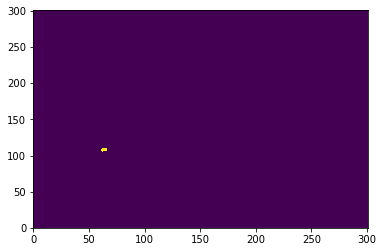

In [80]:
#Instead of labelling the 2D grid using scipy ndimage (which just gets > THRESH
#   objects) with get_filtered_frame(), use watershedding from tobac
#This requires a conversion from the pyart grid object to an Iris cube
colmax = grid_obj.to_xarray()[field].max("z")
for n in colmax.coords:
    if n not in ["time","x","y"]:
        colmax = colmax.drop(n)
colmax = colmax.where(~colmax.isnull(),0).to_iris()

#Set the segmentation and feature ID parameters for tobac. This will need to 
# be set as an option in the TINT parameter set, eventually.
parameters_features={}
parameters_segmentation={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=params["WATERSHED_SMOOTHING"]
parameters_features['threshold']=params["WATERSHED_THRESH"]
parameters_features['threshold']=params["WATERSHED_THRESH"]
parameters_features['n_erosion_threshold']=params["WATERSHED_EROSION"]
parameters_segmentation['threshold']=params["FIELD_THRESH"]

#Run the tobac feature detection
Features=tobac.feature_detection.feature_detection_multithreshold(colmax,grid_size[1],**parameters_features)
if Features is None:
   frame = np.zeros(masked.data.shape)
else:
   #Segmentation using tobac based on a single threshold and Feature locations
   Mask_refl,Features=tobac.segmentation.segmentation(Features,colmax,grid_size[1],**parameters_segmentation)
   #Clear small objects

#CLEAR SMALL ECHOES
#plt.pcolormesh(clear_small_echoes(Mask_refl.data, masked.data, 21, 30, 2, params['FIELD_THRESH']))
label_image=np.copy(Mask_refl.data)
grid=masked.data

params["MIN_SIZE"] = 20
params["MIN_HGT"] = 1
params["MIN_VOL"] = 20

min_size = params['MIN_SIZE'] / np.prod(grid_size[1:]/1000)
min_vol = params['MIN_VOL'] / np.prod(grid_size/1000)
min_height = params['MIN_HGT'] / np.prod(grid_size[0]/1000)
thresh=30

flat_image = pd.Series(label_image.flatten())
flat_image = flat_image[flat_image > 0]
size_table = flat_image.value_counts(sort=False)
small_objects = size_table.keys()[size_table < min_size]

for obj in small_objects:
    label_image[label_image == obj] = 0

for obj in np.unique(label_image):
    if obj > 0:
        heights = (np.where(grid[:,label_image==obj] > thresh))[0]
        if (((grid[:,label_image == obj] > thresh).sum()) < min_vol) | \
                     ((heights.max() - heights.min()) < min_height):
            label_image[label_image == obj] = 0

cnt=1
for obj in np.unique(label_image):
    if obj > 0:
        label_image[label_image==obj] = cnt
        cnt=cnt+1
plt.pcolormesh(label_image)

In [45]:
self.record.update_scan_and_time(grid_obj1, grid_obj2)

print(self.record.interval)Mask_refl

0:06:00


In [69]:
from tint.matching import *

#Test matching
LARGE_NUM=1000
params=self.params
record=self.record
global_shift = get_global_shift(raw1, raw2, self.params)
image1 = frame1
image2 = frame2
current_objects = self.current_objects

#locate_all_objects()
nobj1 = np.max(image1)
nobj2 = np.max(image2)

if (nobj2 == 0) or (nobj1 == 0):
    print('No echoes to track!')

obj_match = np.full((nobj1, np.max((nobj1, nobj2))),
                    LARGE_NUM, dtype='f')

#for all the objects in frame1...look at object 4 which splits in frame2
for obj_id1 in np.arange(nobj1) + 1:
    obj1_extent = get_obj_extent(image1, obj_id1)
    shift = get_ambient_flow(obj1_extent, image1,
                             image2, params, record.grid_size)
    if shift is None:
        record.count_case(5)
        shift = global_shift

    shift = correct_shift(shift, current_objects, obj_id1,
                          global_shift, record, params)

    search_box = predict_search_extent(obj1_extent, shift,
                                       params, record.grid_size)
    search_box = check_search_box(search_box, image2.shape)
    objs_found = find_objects(search_box, image2)
    disparity = get_disparity_all(objs_found, image2,
                                  search_box, obj1_extent)
    obj_match = save_obj_match(obj_id1, objs_found, disparity, obj_match,
                                       params)

#get_pairs() first gets an N x M matrix of "disparity", where N is the number
# of objects in frame1, and M is the number of objects in frame2. This matrix is 
# only filled if the objects are within the search radius in frame2, otherwise set to
# large num. For the example above:
# obj_match = array([[1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      ,   24.265465, 1000.      ,
#           18.375286, 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ],
#        [1000.      , 1000.      , 1000.      , 1000.      , 1000.      ,
#         1000.      , 1000.      , 1000.      ]], dtype=float32)

print(obj_match[1,:])

[1000.           2.3271778 1000.        1000.          31.417053
 1000.        1000.        1000.       ]


Text(0, 0.5, 'Height (m)')

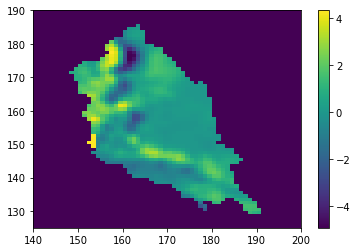

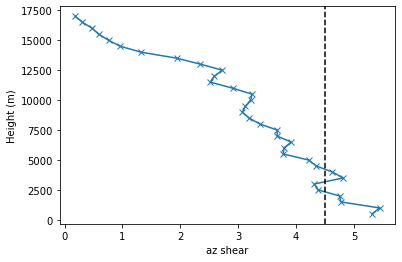

In [22]:
#Testing az shear for Melbourne xmas day storm

plt.pcolormesh(frame2==5)
grid1=grid_obj2; image1=frame2; field="corrected_reflectivity"; params=tracks_obj.params; az_field="azshear"; record=tracks_obj.record

unit_dim = record.grid_size
unit_alt = unit_dim[0]/1000
unit_len = unit_dim[1]/1000
unit_area = (unit_dim[1]*unit_dim[2])/(1000**2)
unit_vol = (unit_dim[0]*unit_dim[1]*unit_dim[2])/(1000**3)

#Set up azimuthal shear 3d array
raw3D = grid1.fields[field]['data'].data
if params["AZI_SHEAR"]:
    if az_field in list(grid1.fields.keys()):
       raw3D_az = grid1.fields[az_field]['data'].data
       raw3D_az = np.where(raw3D_az == -9999, np.nan, raw3D_az)
       az_hidx = (np.arange(raw3D.shape[0])*unit_alt >= params["AZH1"]) &\
           (np.arange(raw3D.shape[0])*unit_alt <= params["AZH2"])
    else: 
       print("AZI_SHEAR parameter is TRUE, but can't find "+az_field+" in the grid file for"+pyart.util.datetime_from_grid(grid1).strftime())

obj=5
plt.pcolormesh(np.where(image1==obj, raw3D_az, np.nan)[5]); plt.colorbar()
plt.ylim([125,190]); plt.xlim([140,200])

plt.figure()
plt.plot(np.nanpercentile(np.abs(np.where(image1==obj, raw3D_az, np.nan)), 99.5, axis=(1,2)), grid_obj2.to_xarray().z.values, marker="x")
plt.gca().axvline(4.5,color="k",ls="--")
plt.xlabel("az shear")
plt.ylabel("Height (m)")

nan